In [1]:
#!cti2yaml ch4_smooke.cti

In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

Initialize

In [3]:
scheme = "ch4_smooke"
# Initialize gas and FreeFlame objects
gas = ct.Solution(scheme+'.yaml', scheme+'_mix')
# Set the initial conditions (if needed)
gas.TPX = 300.0, ct.one_atm, {'CH4': 1, 'O2': 2, 'N2': 7.52}

Initial Properties

In [4]:
Ini_Temp=gas.T
# Get properties
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s
cp = gas.cp

species_names = gas.species_names
molar_masses = gas.molecular_weights/1000  # Molar masses in kg/mol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y
mol_frac = gas.X

print(gas())
    
print("-------------------------------------------------------")
print("-------------------------------------------------------\n\n")
print(f"Density (rho_0):\t {density:.4e} kg/m³")
print(f"Kine Visc (nu_0):\t {kinematic_viscosity:.4e} m²/s")
print(f"cp: \t\t\t{cp:.2f} ")
print(f"Therm Cond:(lambda)\t {thermal_conductivity:.4e} W/m/K\n\n")

for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]:.4f}")  # Print molar mass in SI units
    print(f"Mass Fraction: {mass_fractions[i]:.6f}")
    print(f"Mole Fraction: {mol_frac[i]:.6f}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]:.4e}")
    print("")


  ch4_smooke_mix:

       temperature   300 K
          pressure   1.0133e+05 Pa
           density   1.1225 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.5459e+05       -7.0351e+06  J
   internal energy       -3.4485e+05       -9.5295e+06  J
           entropy            7247.7        2.0028e+05  J/K
    Gibbs function       -2.4289e+06       -6.7119e+07  J
 heat capacity c_p            1077.3             29770  J/K
 heat capacity c_v            776.45             21456  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               CH4          0.055187          0.095057           -54.676
                O2           0.22014           0.19011           -26.334
                N2           0.72467           0.71483          

Print out for the Input_Config file

In [5]:
print("##############################################")
print("c\tFlow Field Solver")
print("#d\tq\trho_0\t\tnu_0\t\tF_x\tF_y\tF_z\tp_th\tM_av")
print(f"3\t27\t{density:.4e}\t{kinematic_viscosity:.4e}\t0\t0\t0\t101325\t0.027633\n")

print("c\tSpecies Field Solver")
print("#d\tq\tNb_spec\tMref")
print(f"2\t5\t{gas.n_species}\t{gas.mean_molecular_weight/1000:5f}" )
print("#name\tMolar Mass")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {molar_masses[i]:.6f}")
    
print("\n\n\nc\tSpecies Field Initial Conditions")
print("#    outside=1, in domain=-1")
print("# ----------------------------------\n\n\n\n\n\n")
print("Tanh\n")
print("# (INLET)")
print(f"1\t1\t{gas.n_species}")
print("#    Initial mass fractions (Inlet)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions[i]:.6f}", end="    " if i % 2 == 0 else "\n")

print("\n#    Initial diffusion coefficients (Inlet)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs[i]:.4e}", end="    " if i % 2 == 0 else "\n")
    
print("\n# (FLOW DOMAIN)")
print(f"3\t-1\t{gas.n_species}")
print("#    Initial mass fractions (Flow)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions[i]:.6f}", end="    " if i % 2 == 0 else "\n")

print("\n#    Initial diffusion coefficients (Flow)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs[i]:.4e}", end="    " if i % 2 == 0 else "\n")

##############################################
c	Flow Field Solver
#d	q	rho_0		nu_0		F_x	F_y	F_z	p_th	M_av
3	27	1.1225e+00	1.6058e-05	0	0	0	101325	0.027633

c	Species Field Solver
#d	q	Nb_spec	Mref
2	5	17	0.027633
#name	Molar Mass
CH4    0.016043
O2     0.031998
H2O    0.018015
H2O2   0.034014
CO2    0.044009
CH3    0.015035
HO2    0.033006
CH2O   0.030026
HCO    0.029018
CH3O   0.031034
CO     0.028010
OH     0.017007
H      0.001008
O      0.015999
H2     0.002016
AR     0.039950
N2     0.028014



c	Species Field Initial Conditions
#    outside=1, in domain=-1
# ----------------------------------






Tanh

# (INLET)
1	1	17
#    Initial mass fractions (Inlet)
CH4    0.055187    O2     0.220141
H2O    0.000000    H2O2   0.000000
CO2    0.000000    CH3    0.000000
HO2    0.000000    CH2O   0.000000
HCO    0.000000    CH3O   0.000000
CO     0.000000    OH     0.000000
H      0.000000    O      0.000000
H2     0.000000    AR     0.000000
N2     0.724672    
#    Initial diffusion coeff

flame domain initialization

In [6]:
# Define the species names in an array
num_species = len(species_names)

# Define the domain size and initial grid
x_start = 0.00593582
x_end = 0.0259358  # Total domain size
n_points = 4000
dx = 5e-6
HR = []

# Create a monotonically increasing grid with specified dx
grid = [x_start + i * dx for i in range(n_points)]

# Create the 1D flame simulation object with the corrected grid
f = ct.FreeFlame(gas, grid=grid)
f.energy_enabled = True                                 # Energy equation enabled

tol_ss = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for steady-state problem
tol_ts = [1.0e-5, 1.0e-9]  # tolerance [rtol atol] for time stepping
f.flame.set_steady_tolerances(default=tol_ss)
f.flame.set_transient_tolerances(default=tol_ts) 
f.inlet.X = gas.X                   # Inlet condition on mass fraction
f.inlet.T = gas.T                   # Inlet condition on temperature

# Specify other options
f.set_time_step(4.0e-9, [2, 5, 10, 20, 40])         # Set time steps (in seconds) whenever Newton convergence fails 
f.set_refine_criteria(ratio=3.0, slope=0.05, curve=0.05)

Essential flame data before solving!!!

In [7]:
# Gather and print essential data about the flame
# Flame properties
flame_speed = f.velocity[0]  # Mixture-averaged flame speed in m/s
final_temperature = f.T[-1]  # Final temperature of the flame in K
final_pressure = f.P  # Final pressure of the flame in Pa
# Calculate the density profile
maxdensity = max(f.density)
mindensity = min(f.density)
flame_thickness = f.flame.grid[1] - f.flame.grid[0]  # Flame thickness in meters

# Species mass fractions
species_names = gas.species_names
species_mass_fractions = f.Y[-1]  # Mass fractions at the flame front

# Thermal properties
thermal_conductivity = f.thermal_conductivity[-1]  # Thermal conductivity at the flame front in W/m-K
heat_capacity = f.cp[-1]  # Heat capacity at constant pressure at the flame front in J/kg-K
heat_release_rate = max(f.heat_release_rate)
max_heat_release_position = f.grid[f.heat_release_rate.argmax()]  # Position corresponding to the maximum heat release rate in meters

# Reaction rates
reaction_rates = f.net_rates_of_progress  # Reaction rates at the flame front

# Print essential data
print(f"Mixture-Averaged Flame Speed: {flame_speed:.3f} m/s")
print(f"Final Flame Temperature: {final_temperature:.3f} K")
print(f"Final Flame Pressure: {final_pressure:.3f} Pa")
print(f"Max Density: {maxdensity:.3e} (kg/m^3)")
print(f"Min Density: {mindensity:.3e} (kg/m^3)")
print(f"Flame Thickness: {flame_thickness:.3e} meters")
print(f"Thermal Conductivity at Flame Front: {thermal_conductivity:.4f} W/m-K")
print(f"Heat Capacity at Flame Front: {heat_capacity:.3f} J/kg-K")
print(f"Maximum Heat Release Rate: {heat_release_rate} W/m^3")
print(f"Position of Maximum Heat Release Rate: {max_heat_release_position} meters")

print("\nSpecies Mass Fractions at Flame Front:")
for i, species in enumerate(species_names):
    print(f"{species}: {species_mass_fractions[i]:.3e}")


Mixture-Averaged Flame Speed: 0.000 m/s
Final Flame Temperature: 300.000 K
Final Flame Pressure: 101325.000 Pa
Max Density: 1.123e+00 (kg/m^3)
Min Density: 1.123e+00 (kg/m^3)
Flame Thickness: 5.000e-06 meters
Thermal Conductivity at Flame Front: 0.0273 W/m-K
Heat Capacity at Flame Front: 1077.330 J/kg-K
Maximum Heat Release Rate: -3.48345567927767e-61 W/m^3
Position of Maximum Heat Release Rate: 0.00593582 meters

Species Mass Fractions at Flame Front:
CH4: 7.247e-01
O2: 7.247e-01
H2O: 7.247e-01
H2O2: 7.247e-01
CO2: 7.247e-01
CH3: 7.247e-01
HO2: 7.247e-01
CH2O: 7.247e-01
HCO: 7.247e-01
CH3O: 7.247e-01
CO: 7.247e-01
OH: 7.247e-01
H: 7.247e-01
O: 7.247e-01
H2: 7.247e-01
AR: 7.247e-01
N2: 7.247e-01


Main FLAME SOLVING

In [8]:
# Solve the flame simulation
f.solve(loglevel=1, refine_grid=False, auto=False)
f.save('Results/Cantera_' + scheme + '_' + str(Ini_Temp)+'.csv', 'energy', 'solution with the energy equation enabled')


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps         9e-09      7.461
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     6.834e-08      7.081
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.627e-06      6.191
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps     1.122e-05       6.97
Attempt Newton solution of steady-state problem...    failure. 
Take 40 timesteps       0.01106      1.319
Attempt Newton solution of steady-state problem...    success.

Problem solved on [4000] point grid(s).

..............................................................................
grid refinement disabled.
Solution saved to file Results/Cantera_ch4_smooke_300.0.csv as solution energy.


C:\Users\Safari\AppData\Local\Temp\ipykernel_8420\3460873113.py:3: DeprecationWarning: XML_Node::write: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  f.save('Results/Cantera_' + scheme + '_' + str(Ini_Temp)+'.csv', 'energy', 'solution with the energy equation enabled')


Flame parameters after solving

In [17]:
gas()
# Access molar masses, mass fractions, and diffusion coefficients after the flame simulation
molar_masses_after = f.gas.molecular_weights / 1000  # Molar masses in kg/mol
mass_fractions_after = f.gas.Y
diff_coeffs_after = f.gas.mix_diff_coeffs

# Print molar masses after the flame simulation
print("\n\n#    Molar Masses (AFTER FLAME SIMULATION)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {molar_masses_after[i]:.6f}")



  ch4_smooke_mix:

       temperature   2194.8 K
          pressure   1.0133e+05 Pa
           density   0.15192 kg/m^3
  mean mol. weight   27.36 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.5792e+05       -7.0568e+06  J
   internal energy       -9.2489e+05       -2.5305e+07  J
           entropy            9873.8        2.7015e+05  J/K
    Gibbs function       -2.1929e+07       -5.9997e+08  J
 heat capacity c_p            1511.3             41350  J/K
 heat capacity c_v            1207.4             33035  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2         0.0082965          0.007094           -34.049
               H2O           0.11925           0.18112           -42.846
              H2O2        1.2733e-07        1.0242e-07       

AFTER FLAME DATA FOR input_Config

In [18]:
print("# (AFTER FLAME EQUILIBRIUM)")
print(f"-1\t-1\t{gas.n_species}")
# Print mass fractions after the flame simulation
print("#    Mass Fractions (AFTER FLAME SIMULATION)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions_after[i]:.6f}", end="    " if i % 2 == 0 else "\n")

# Print diffusion coefficients after the flame simulation
print("\n#    Diffusion Coefficients (AFTER FLAME SIMULATION)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs_after[i]:.4e}", end="    " if i % 2 == 0 else "\n")
    
print("\n#    Mass Fractions OUTLET)")
print(f"2\t1\t{gas.n_species}")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions_after[i]:.6f}", end="    " if i % 2 == 0 else "\n")

# Print diffusion coefficients after the flame simulation
print("\n#    Diffusion Coefficients (OUTLET)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs_after[i]:.4e}", end="    " if i % 2 == 0 else "\n")

# (AFTER FLAME EQUILIBRIUM)
-1	-1	17
#    Mass Fractions (AFTER FLAME SIMULATION)
CH4    0.000000    O2     0.008297
H2O    0.119254    H2O2   0.000000
CO2    0.132917    CH3    0.000000
HO2    0.000001    CH2O   0.000000
HCO    0.000000    CH3O   0.000000
CO     0.011756    OH     0.002468
H      0.000028    O      0.000257
H2     0.000350    AR     -0.000000
N2     0.724672    
#    Diffusion Coefficients (AFTER FLAME SIMULATION)
CH4    6.7576e-04    O2     6.1992e-04
H2O    8.3807e-04    H2O2   6.1203e-04
CO2    4.8387e-04    CH3    6.7880e-04
HO2    6.1621e-04    CH2O   5.3400e-04
HCO    5.3842e-04    CH3O   5.2160e-04
CO     6.1106e-04    OH     9.3515e-04
H      3.7101e-03    O      9.5295e-04
H2     2.2181e-03    AR     6.0213e-04
N2     6.2852e-04    
#    Mass Fractions OUTLET)
2	1	17
CH4    0.000000    O2     0.008297
H2O    0.119254    H2O2   0.000000
CO2    0.132917    CH3    0.000000
HO2    0.000001    CH2O   0.000000
HCO    0.000000    CH3O   0.000000
CO     0.011756    O

In [19]:
print("c\tSpecies Field Boundary Conditions")
print("#number of boundaries for the species solver")
print("2")
print("#index	in_zone	out	type	<parameter name>    <parameter value>")
print(f"1\t3\t1\t102\t{gas.n_species}\t" + "\t".join([f"{species_names[i]:<6}\t{mass_fractions[i]:.6f}" for i in range(len(species_names))]))
print(f"2\t3\t2\t104\t{gas.n_species}\t" + "\t".join([f"{species_names[i]:<6}" for i in range(len(species_names))]))

c	Species Field Boundary Conditions
#number of boundaries for the species solver
2
#index	in_zone	out	type	<parameter name>    <parameter value>
1	3	1	102	17	CH4   	0.055187	O2    	0.220141	H2O   	0.000000	H2O2  	0.000000	CO2   	0.000000	CH3   	0.000000	HO2   	0.000000	CH2O  	0.000000	HCO   	0.000000	CH3O  	0.000000	CO    	0.000000	OH    	0.000000	H     	0.000000	O     	0.000000	H2    	0.000000	AR    	0.000000	N2    	0.724672
2	3	2	104	17	CH4   	O2    	H2O   	H2O2  	CO2   	CH3   	HO2   	CH2O  	HCO   	CH3O  	CO    	OH    	H     	O     	H2    	AR    	N2    


In [20]:
np.max(f.velocity)-np.min(f.velocity)

3.3989209475266184

In [21]:
# Gather and print essential data about the flame

# Flame properties
flame_speed = f.velocity[0]  # Mixture-averaged flame speed in m/s
flame_speed_last = f.velocity[-1]  # Mixture-averaged flame speed in m/s
final_temperature = f.T[-1]  # Final temperature of the flame in K
final_pressure = f.P  # Final pressure of the flame in Pa
# Calculate the density profile
maxdensity = max(f.density)
flame_thickness = f.flame.grid[1] - f.flame.grid[0]  # Flame thickness in meters

# Species mass fractions
species_names = gas.species_names
species_mass_fractions = f.Y[-1]  # Mass fractions at the flame front

# Thermal properties
thermal_conductivity = f.thermal_conductivity[-1]  # Thermal conductivity at the flame front in W/m-K
heat_capacity = f.cp[-1]  # Heat capacity at constant pressure at the flame front in J/kg-K
heat_release_rate = max(f.heat_release_rate)
max_heat_release_position = f.grid[f.heat_release_rate.argmax()]  # Position corresponding to the maximum heat release rate in meters

# Reaction rates
reaction_rates = f.net_rates_of_progress  # Reaction rates at the flame front

# Print essential data
print(f"Mixture-Averaged Flame Speed: {flame_speed:.3f} m/s")
print(f"Burnt Gas Flame Speed: {flame_speed_last:.3f} m/s")
print(f"Final Flame Temperature: {final_temperature:.3f} K")
print(f"Final Flame Pressure: {final_pressure:.3f} Pa")
print(f"Max Density: {maxdensity:.3e} (kg/m^3)")
print(f"Flame Thickness: {flame_thickness:.3e} meters")
print(f"Thermal Conductivity at Flame Front: {thermal_conductivity:.4f} W/m-K")
print(f"Heat Capacity at Flame Front: {heat_capacity:.3f} J/kg-K")
print(f"Maximum Heat Release Rate: {heat_release_rate} W/m^3")
print(f"Position of Maximum Heat Release Rate: {max_heat_release_position} meters")

print("\nSpecies Mass Fractions at Flame Front:")
for i, species in enumerate(species_names):
    print(f"{species}: {species_mass_fractions[i]:.3e}")

#print("\nReaction Rates at Flame Front:")
#for i, reaction in enumerate(gas.reaction_equations()):
#    print(f"Reaction {i + 1}: {reaction} - Rate: {reaction_rates[i]}")

f.write_csv('Results/Cantera_'+scheme+'_'+str(Ini_Temp)+'_data.csv', species='Y', quiet=False, normalize=True)  # Write the velocity, temperature, density, and mole fractions 
                                               # to a CSV file

Mixture-Averaged Flame Speed: 0.532 m/s
Burnt Gas Flame Speed: 3.931 m/s
Final Flame Temperature: 2194.768 K
Final Flame Pressure: 101325.000 Pa
Max Density: 1.123e+00 (kg/m^3)
Flame Thickness: 5.000e-06 meters
Thermal Conductivity at Flame Front: 0.1539 W/m-K
Heat Capacity at Flame Front: 1511.321 J/kg-K
Maximum Heat Release Rate: 6666626634.046086 W/m^3
Position of Maximum Heat Release Rate: 0.01309082 meters

Species Mass Fractions at Flame Front:
CH4: 7.247e-01
O2: 7.247e-01
H2O: 7.247e-01
H2O2: 7.247e-01
CO2: 7.247e-01
CH3: 7.247e-01
HO2: 7.247e-01
CH2O: 7.247e-01
HCO: 7.247e-01
CH3O: 7.247e-01
CO: 7.247e-01
OH: 7.247e-01
H: 7.247e-01
O: 7.247e-01
H2: 7.247e-01
AR: 7.247e-01
N2: 7.247e-01
Solution saved to 'Results/Cantera_ch4_smooke_300.0_data.csv'.


PLOTS

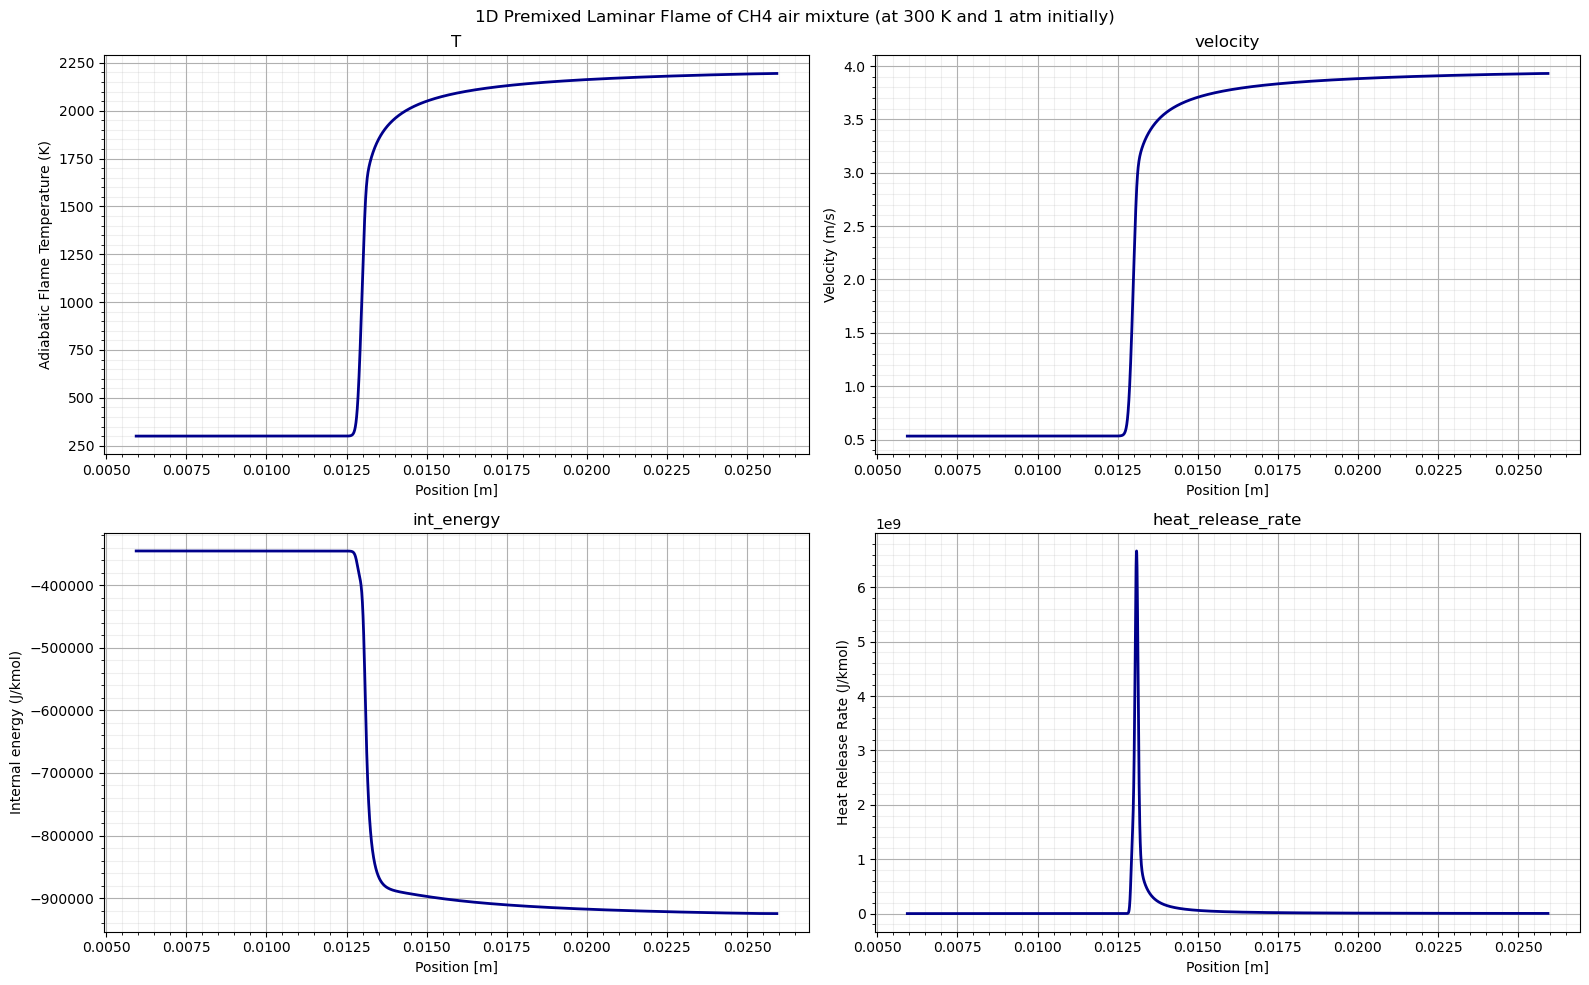

In [22]:
# Create subplots for the temperature, velocity, internal energy, and heat release rate
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle('1D Premixed Laminar Flame of CH4 air mixture (at 300 K and 1 atm initially)')

variables = ['T', 'velocity', 'int_energy', 'heat_release_rate']
y_labels = ['Adiabatic Flame Temperature (K)', 'Velocity (m/s)', 'Internal energy (J/kmol)', 'Heat Release Rate (J/kmol)']

for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(f.grid, getattr(f, variables[i]), color='darkblue', linewidth=2)
    ax.set_title(variables[i])
    ax.set_xlabel('Position [m]')
    ax.set_ylabel(y_labels[i])
    ax.grid(which='major')
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.2)

plt.tight_layout()
plt.savefig(f'Results/1D_'+scheme+'_'+str(Ini_Temp)+'_prop.png', dpi=300)
plt.show()



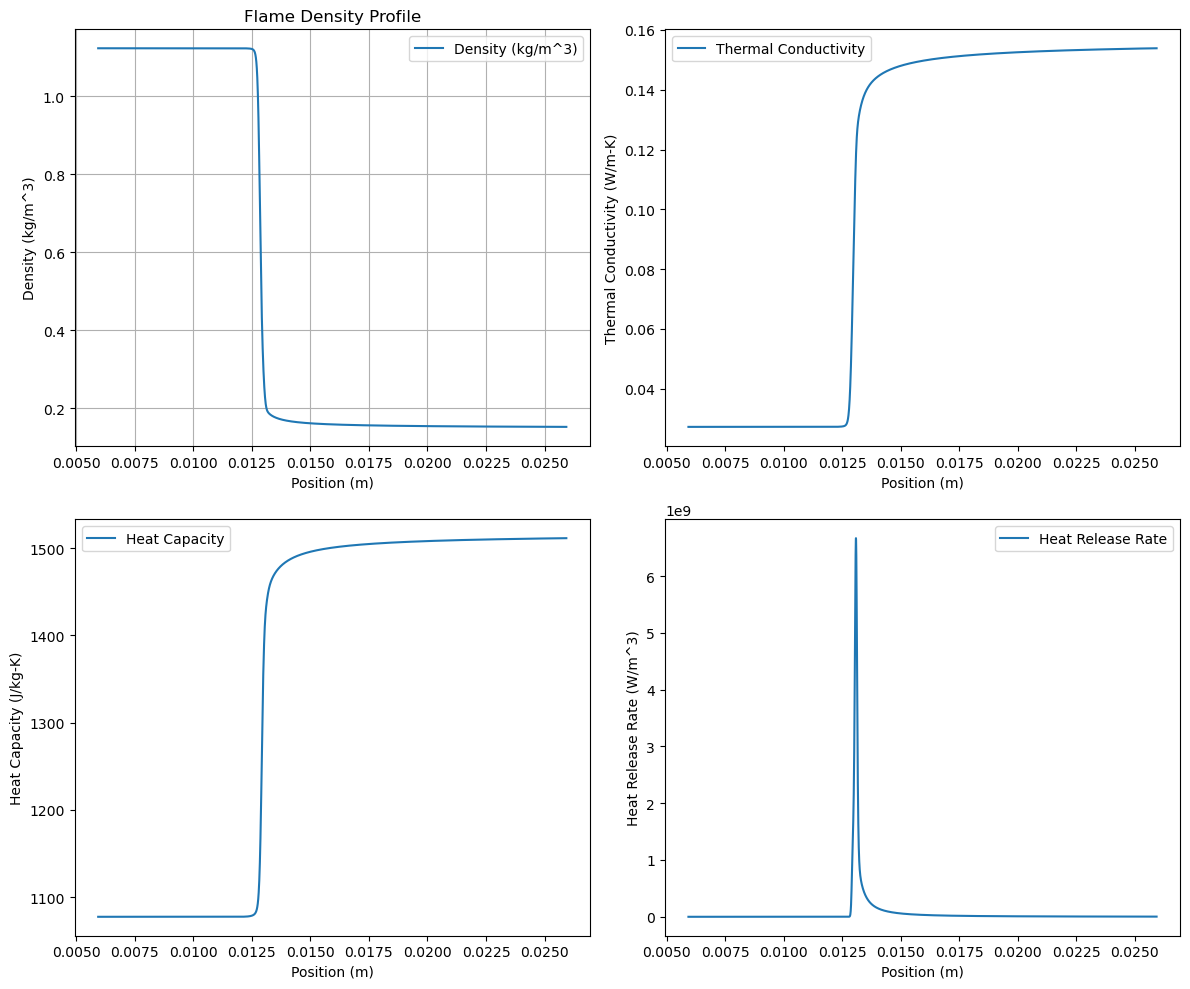

In [23]:
# Create subplots for the features
plt.figure(figsize=(12, 10))

# Density Profile
plt.subplot(2, 2, 1)
plt.plot(grid, f.density, label='Density (kg/m^3)')
plt.xlabel('Position (m)')
plt.ylabel('Density (kg/m^3)')
plt.title('Flame Density Profile')
plt.grid(True)
plt.legend()

# Thermal Properties
plt.subplot(2, 2, 2)
plt.plot(f.grid, f.thermal_conductivity, label='Thermal Conductivity')
plt.xlabel('Position (m)')
plt.ylabel('Thermal Conductivity (W/m-K)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(f.grid, f.cp, label='Heat Capacity')
plt.xlabel('Position (m)')
plt.ylabel('Heat Capacity (J/kg-K)')
plt.legend()

# Heat Release Rate
plt.subplot(2, 2, 4)
plt.plot(f.grid, f.heat_release_rate, label='Heat Release Rate')
plt.xlabel('Position (m)')
plt.ylabel('Heat Release Rate (W/m^3)')
plt.legend()

plt.tight_layout()
plt.savefig(f'Results/1D_'+scheme+'_'+str(Ini_Temp)+'_prop_2.png', dpi=300)
plt.show()

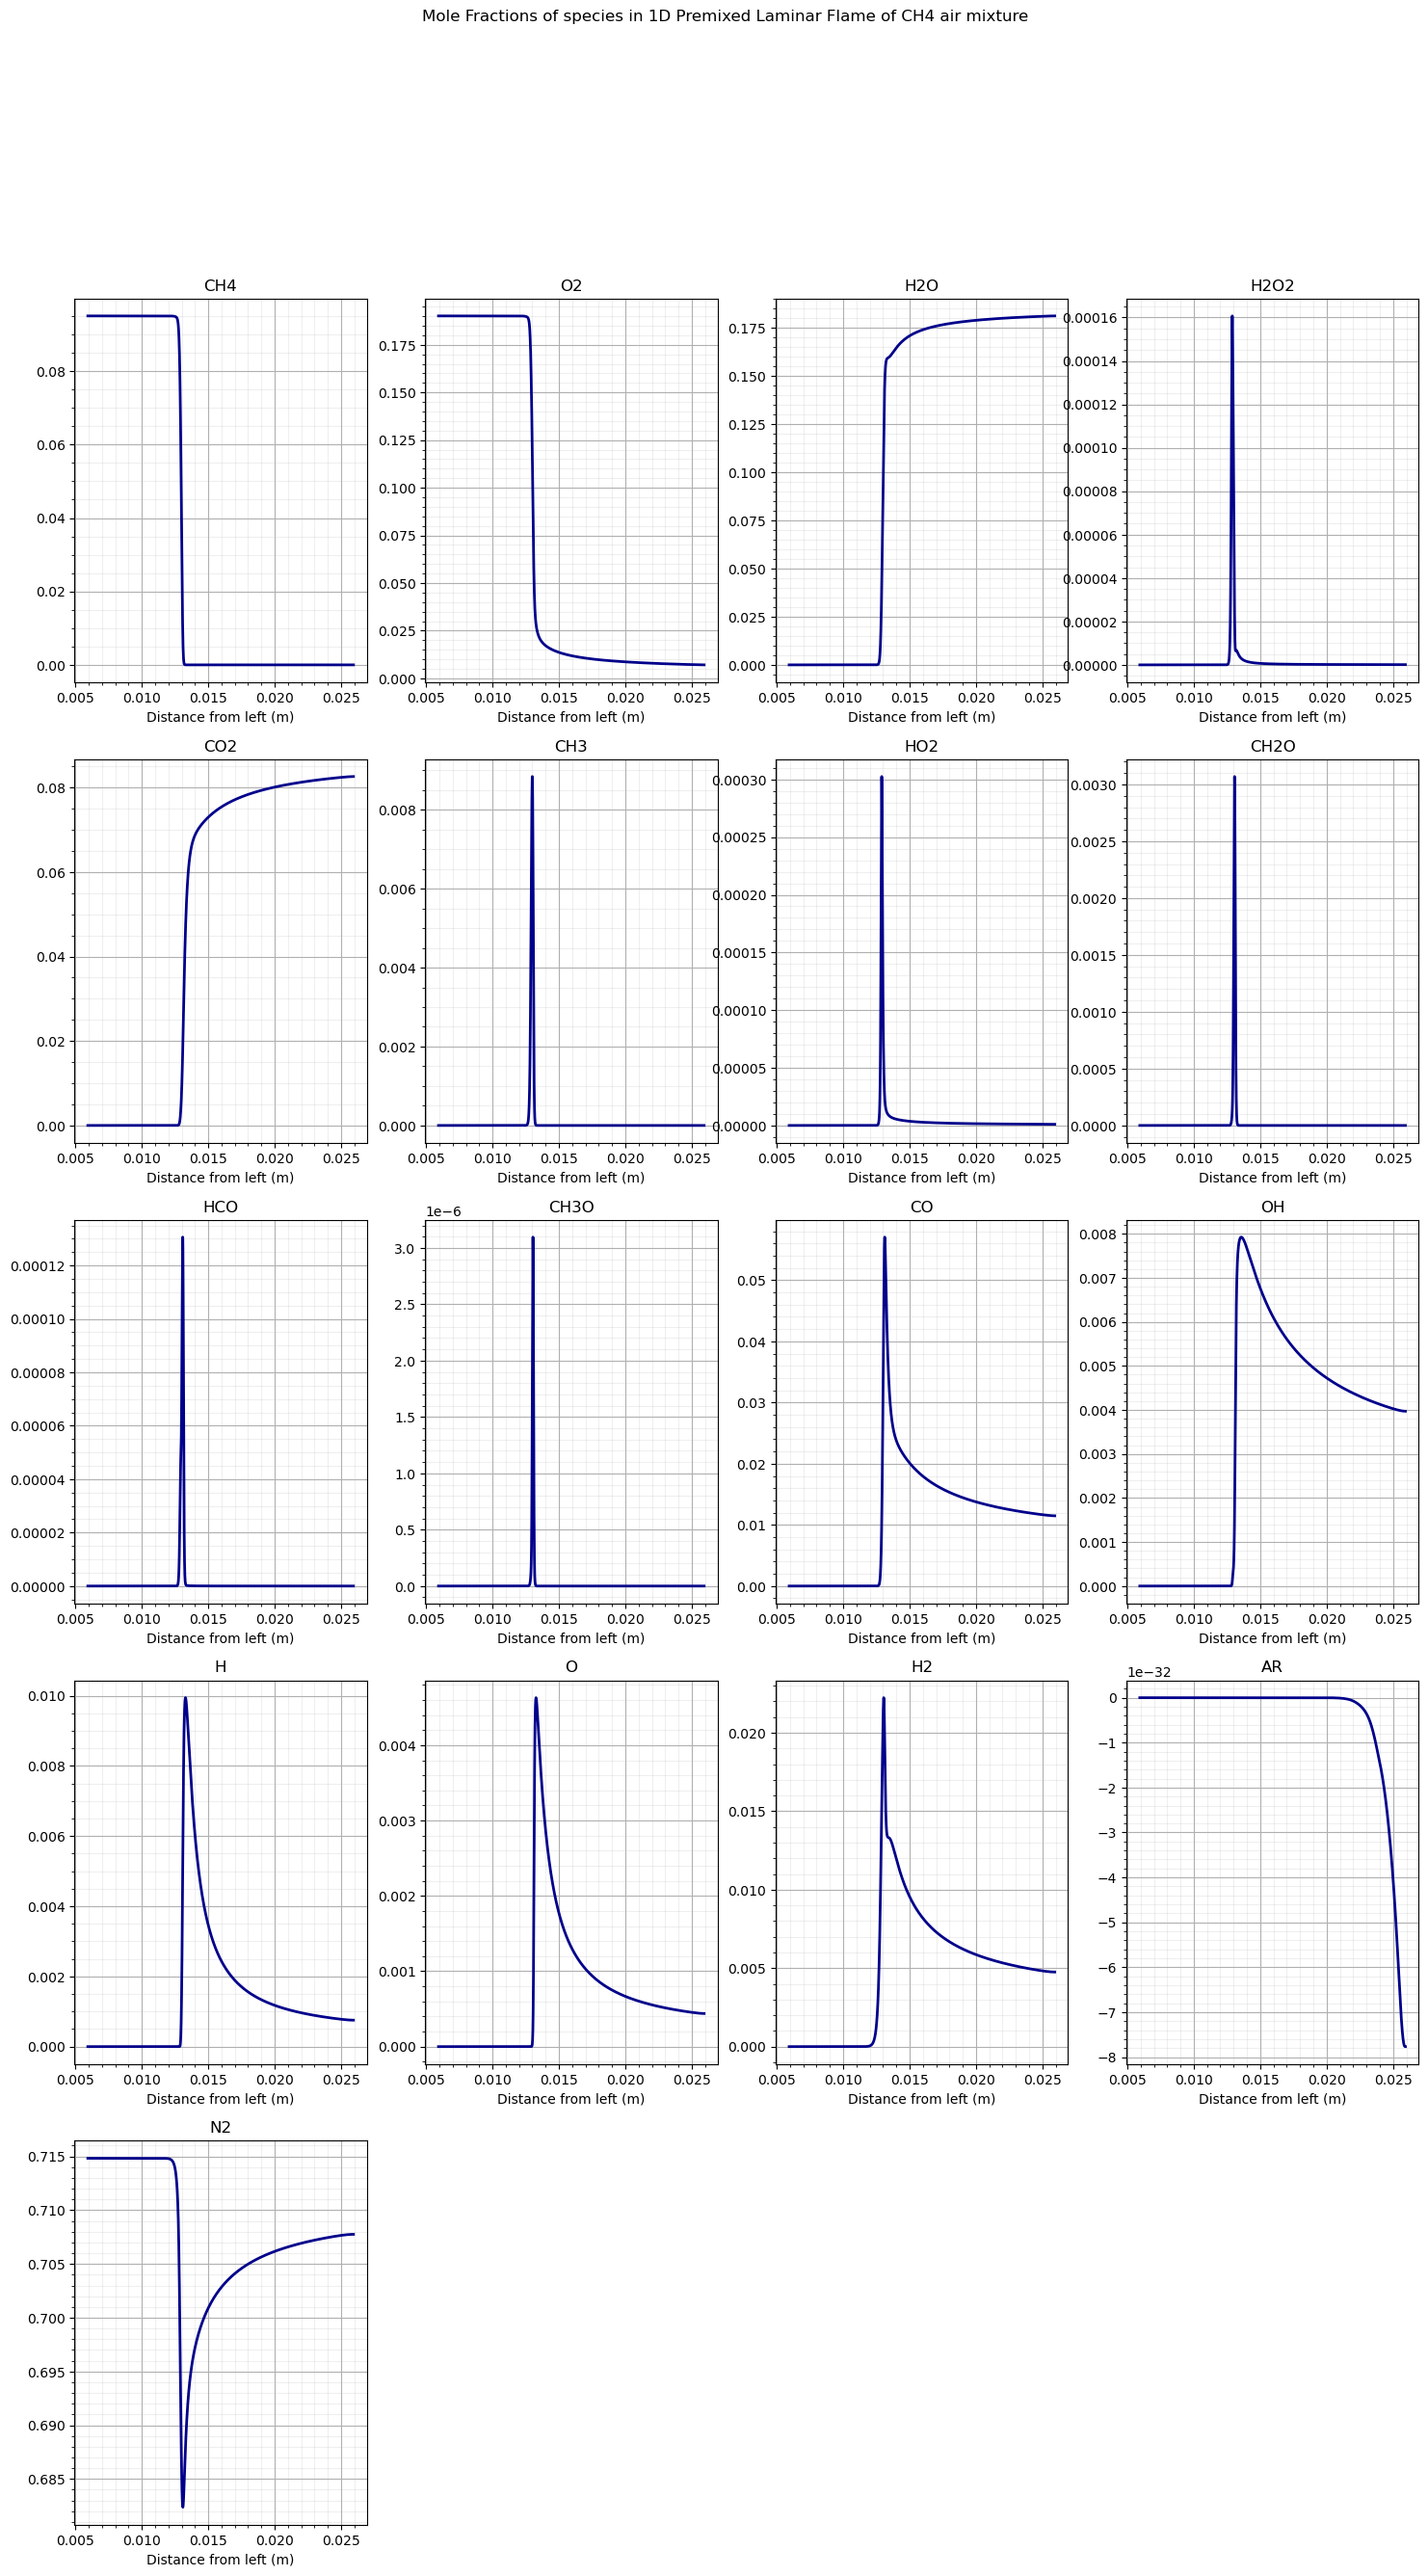

In [24]:

# Create subplots for the mole fractions of species
num_rows = num_species // 4 + (num_species % 4 > 0)  # Calculate the number of rows
fig, axs = plt.subplots(num_rows, 4, figsize=(18, 6 * num_rows))
plt.suptitle('Mole Fractions of species in 1D Premixed Laminar Flame of CH4 air mixture')

for i, species_name in enumerate(species_names):
    ax = axs[i // 4, i % 4]
    species_index = gas.species_index(species_name)
    ax.plot(f.grid, f.X[species_index, :], color='darkblue', linewidth=2)
    ax.set_title(species_name)
    ax.set_xlabel('Distance from left (m)')
    ax.grid(which='major')
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.2)

# Hide any empty subplots (if num_species is not a multiple of 4)
for i in range(num_species, num_rows * 4):
    fig.delaxes(axs[i // 4, i % 4])

#plt.tight_layout()
plt.savefig(f'Results/1D_'+scheme+'_'+str(Ini_Temp)+'_species.png', dpi=300)
plt.show()